In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics._plot import confusion_matrix as cm
from sklearn.metrics import confusion_matrix
import faiss
from sklearn.utils import resample, shuffle

## Utils

In [2]:
def imageSet(dirActive):
    def getCv2ImgAtIndex(index, labelsCsv):
        ts = labelsCsv['timestamp'][index]
        if not os.path.exists(f'{dirActive}/images/img_{ts}.jpeg'):
             return np.array([])
        img = cv2.resize(cv2.imread(f'{dirActive}/images/img_{ts}.jpeg'),(80,60))
        return img
    labelsCsv = pd.read_csv(f'{dirActive}/labels.csv')
    labelsThatExists = [i for i in range(len(labelsCsv)) if os.path.exists(f'{dirActive}/images/img_{labelsCsv["timestamp"][i]}.jpeg') and labelsCsv['forward/backward'][i] == 1]
    imageArray = np.array([getCv2ImgAtIndex(i,labelsCsv) for i in labelsThatExists])
    leftRightArray = np.array([labelsCsv['left/right'][i] for i in labelsThatExists])
    return imageArray, leftRightArray, labelsCsv

def processedImageSet(imageSet, labelSet, processFunc):
    imageArray = np.array([processFunc(i) for i in imageSet])
    flatImageArray = np.array([image.flatten() for image in imageArray])
    return flatImageArray, labelSet, imageArray, imageSet

def bmxr(im, x=1.5):
    b = im[:,:,0]
    r = im[:,:,2]
    return cv2.subtract(b,cv2.multiply(r,x))

def thresholdIm(im, low=50, high=255):
    e,im = cv2.threshold(im, low, high, cv2.THRESH_BINARY)
    return im

def dispIm(im, label="pic"):
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.title(label)
    plt.show()

def dispGSIm(im, label='pic'):
    plt.imshow(im, cmap='gray', vmin = 0, vmax = 255,interpolation='none')
    plt.title(label)
    plt.show()

## Get train and test set

In [3]:
train_u_images, train_u_labels, labelsCsv_train = imageSet('../data/train_data/dataTrackV2_4/')
test_images, test_labels, labelsCsv_test = imageSet('../data/test_data/dataTrackV2_5/')

## Balance the sampling in the training set

In [4]:
counts = np.bincount(train_u_labels + 1)
print(counts)
dominantClass = 0
dominantClassCount = counts[dominantClass + 1]
print(f'dominant class ({dominantClass}) has {dominantClassCount} samples.')
dominantIndices = np.where(train_u_labels == dominantClass)[0]
X_straight = train_u_images[dominantIndices]
y_straight = train_u_labels[dominantIndices]

X_left, y_left = resample(train_u_images[train_u_labels == -1], train_u_labels[train_u_labels == -1],
                                 replace=True,     # sample with replacement
                                 n_samples=dominantClassCount,    # to match majority class
                                 random_state=42) # reproducible results

X_right, y_right = resample(train_u_images[train_u_labels == 1], train_u_labels[train_u_labels == 1],
                                 replace=True,     # sample with replacement
                                 n_samples=dominantClassCount,    # to match majority class
                                 random_state=42) # reproducible results

train_labels = np.concatenate((y_left,y_straight,y_right))
train_images = np.concatenate((X_left, X_straight, X_right))
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
counts = np.bincount(train_labels + 1)
print(counts)

[ 2158 13609  1547]
dominant class (0) has 13609 samples.
[13609 13609 13609]


## Process the data

In [5]:
def processImage(im):    
    im = bmxr(im,1.25)
    im = thresholdIm(im,8,255)
    
    return im

X_test, y_test, X_test_images, X_test_originals = processedImageSet(test_images, test_labels, processImage)
X_train, y_train, X_train_images, X_train_originals = processedImageSet(train_images, train_labels, processImage)

In [6]:
import random

def displayRandom(ims, originals, k=1):
    for i in range(k):
        ind = random.randint(0, len(ims))
        dispIm(originals[ind],f'og @{ind}')
        dispIm(ims[ind], f'edit @{ind}')

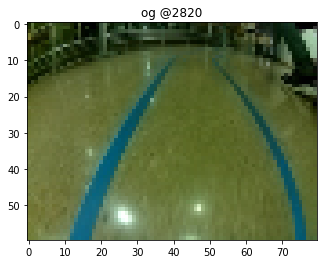

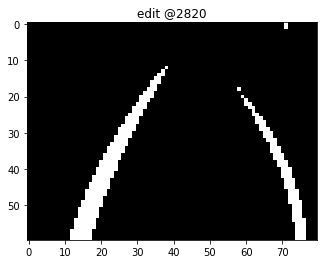

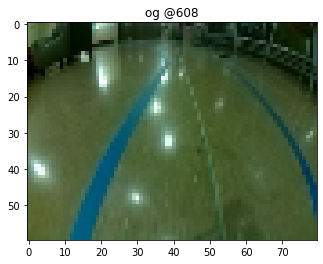

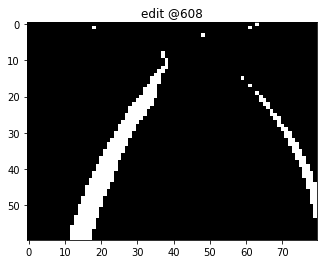

In [7]:
displayRandom(X_test_images, X_test_originals)
displayRandom(X_train_images, X_train_originals)

# K-NearestNeighbours

In [8]:
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices] + 1
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes]) - 1
        return predictions

In [9]:
def runKNN(k):
    knn = FaissKNeighbors(k=k)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    bacc = balanced_accuracy_score(y_test, y_predict)
    print(f'k={k} test accuracy: {acc:.3f} bacc: {bacc:.3f}')
    matrix = confusion_matrix(y_test, y_predict)
    disp=cm.ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['-1','0','1'])
    disp.plot(include_values=True, cmap=plt.cm.Blues);

```
k=1 test accuracy: 0.748 bacc: 0.598
k=3 test accuracy: 0.747 bacc: 0.631
k=5 test accuracy: 0.739 bacc: 0.651
k=7 test accuracy: 0.724 bacc: 0.664
k=9 test accuracy: 0.712 bacc: 0.680
k=11 test accuracy: 0.704 bacc: 0.686
k=13 test accuracy: 0.693 bacc: 0.689
k=15 test accuracy: 0.687 bacc: 0.704
k=17 test accuracy: 0.684 bacc: 0.711
k=19 test accuracy: 0.682 bacc: 0.717
k=21 test accuracy: 0.677 bacc: 0.720
k=23 test accuracy: 0.677 bacc: 0.724
k=25 test accuracy: 0.669 bacc: 0.726
k=27 test accuracy: 0.664 bacc: 0.730
k=29 test accuracy: 0.661 bacc: 0.731
k=31 test accuracy: 0.657 bacc: 0.732
k=33 test accuracy: 0.651 bacc: 0.733
k=35 test accuracy: 0.650 bacc: 0.730
k=37 test accuracy: 0.646 bacc: 0.731
k=39 test accuracy: 0.648 bacc: 0.737
k=41 test accuracy: 0.645 bacc: 0.736
```

k=121 test accuracy: 0.644 bacc: 0.758


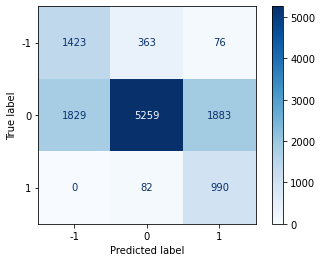

In [13]:
runKNN()

k=1 test accuracy: 0.748 bacc: 0.598


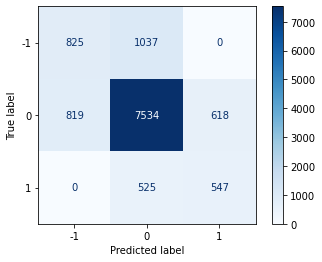

In [12]:
runKNN(1)

k=43 test accuracy: 0.642 bacc: 0.737
k=45 test accuracy: 0.644 bacc: 0.737
k=47 test accuracy: 0.643 bacc: 0.739
k=49 test accuracy: 0.649 bacc: 0.743
k=51 test accuracy: 0.650 bacc: 0.748
k=53 test accuracy: 0.651 bacc: 0.746
k=55 test accuracy: 0.654 bacc: 0.745
k=57 test accuracy: 0.655 bacc: 0.748
k=59 test accuracy: 0.652 bacc: 0.747
k=61 test accuracy: 0.651 bacc: 0.746
k=63 test accuracy: 0.647 bacc: 0.745
k=65 test accuracy: 0.648 bacc: 0.748


KeyboardInterrupt: 

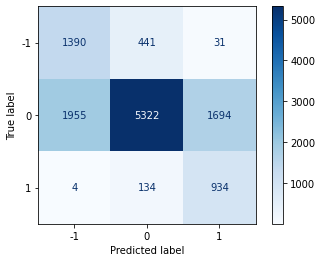

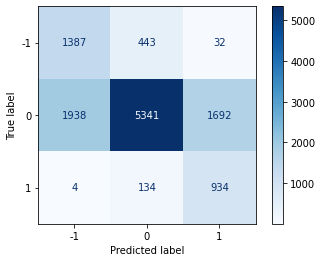

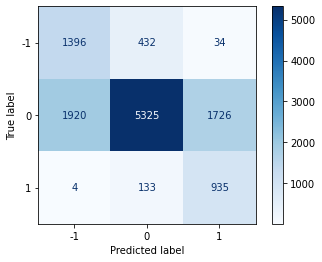

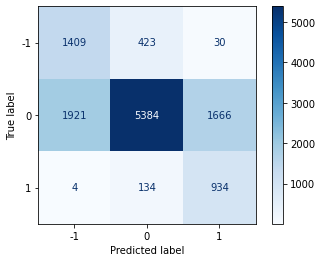

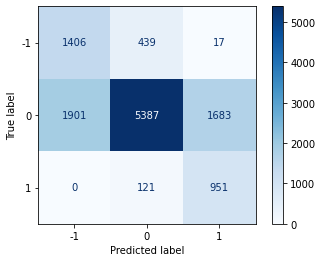

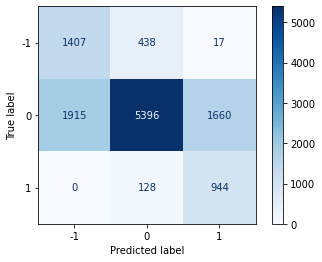

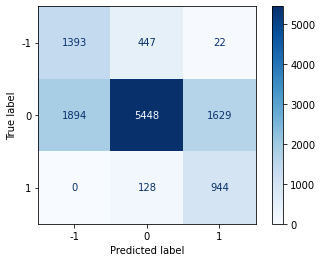

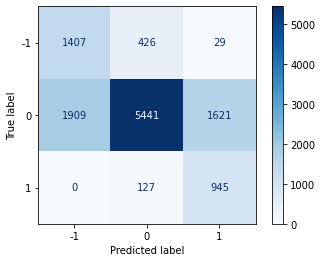

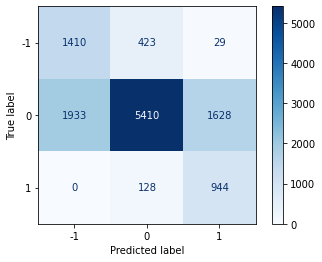

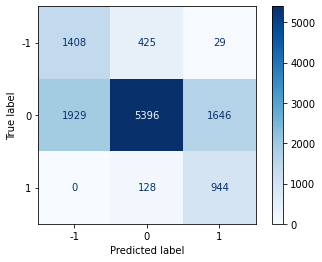

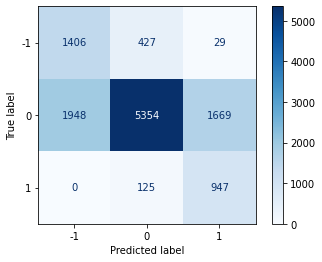

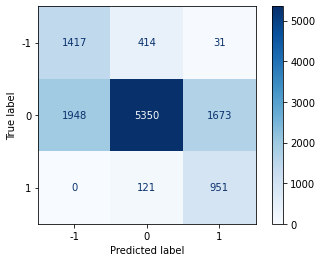

In [10]:
for i in range(43,401,2):
    runKNN(i)
    pass

In [32]:
#from sklearn.neighbors import KNeighborsClassifier
good_knn = FaissKNeighbors(k=5)
good_knn.fit(X_train, y_train)
# y_predict = good_knn.predict(X_test)
# acc = accuracy_score(y_test, y_predict)
# bacc = balanced_accuracy_score(y_test, y_predict)
# print(f'k={51} test accuracy: {acc:.3f} bacc: {bacc:.3f}')

In [36]:
import pickle
save_file_name = '../models/knn_serialized_5_f.pickle'

with open(save_file_name, 'wb') as f:
    pickle.dump(good_knn, f)

TypeError: can't pickle SwigPyObject objects

In [33]:
X_test.shape

(11905, 4800)

In [35]:
%timeit good_knn.predict(np.array([X_test[10]]))

166 ms ± 46.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
